<a href="https://colab.research.google.com/github/fahdfareed/Neural-Network/blob/main/NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import numpy as np
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score


from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, LeakyReLU, Flatten, Dropout, MaxPooling2D

# **Loading Dataset**

You will be using MNIST handwritten digits to create a digit detection system. The dataset contain binary images of handwritten digits, and has has a training set of 60,000 examples, and a test set of 10,000 examples. The dataset can be loaded using the following commands:

> from keras.datasets import mnist

> (trainX, trainY), (testX, testY) = mnist.load_data()

Starter code has already been provided to you. In the load_dataset() function, perform the following tasks:


*   Normalize pixel values between 0 and 1
*   One hot encode true labels using the [to_categorical()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) function.



In [41]:
from keras.datasets import mnist
def load_dataset():
  # loading dataset
  (train_X, train_Y), (test_X, test_Y) = mnist.load_data()
  # processing images- normalizing
  train_X = (train_X)/ float(255)
  test_X = (test_X)/ float(255)

  untest = test_Y

  # processing labels- one hot encoding
  train_Y = to_categorical(train_Y)
  test_Y = to_categorical(test_Y)
  return train_X, train_Y, test_X, test_Y, untest

In [42]:
train_X, train_Y, test_X, test_Y, untested = load_dataset()

# **Part 1**

In the first part, you will be creating a neural network from scratch.  Often the code ishidden behind libraries.  The purpose of this task is to give you hand-on experience withthe mathematical foundations of neural network architectures.  After implementing this task, you will know exactly how forward and backward pass functions are implemented mathematically and in code. 

Reshape the dataset to a 2D array using [NumPy reshape function](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html).

In [43]:
# Reshaping the training data
train_X = train_X.reshape((train_X.shape[0],train_X.shape[1]**2))
test_X  = test_X.reshape((test_X.shape[0],test_X.shape[1]**2))

print('Train: X=%s, Y=%s' % (train_X.shape, train_Y.shape)) #should print "Train: X=(60000, 784), y=(60000,10)"
print('Test: X=%s, Y=%s' % (test_X.shape, test_Y.shape)) #should print "Test: X=(10000, 784), y=(10000,10)"

Train: X=(60000, 784), Y=(60000, 10)
Test: X=(10000, 784), Y=(10000, 10)


In [44]:
class NeuralNetwork():
  
  @staticmethod
  def cross_entropy_loss(y_pred, y_true):
    '''Used as a loss function'''
    log = np.log(y_pred)
    loss = -np.sum(log * y_true)
    return loss

  @staticmethod
  def softmax(Z):
    '''Used as the activation function in output layer'''
    numerator = np.exp(Z)
    output = numerator/numerator.sum(axis = 1, keepdims = True)
    return output

  @staticmethod
  def sigmoid(Z):
    '''Used as the activation function in every hidden layer'''
    sig = 1.0/(1.0 + np.exp(-Z))
    return sig


  def __init__(self, list_of_nodes):
    '''Constructor of our neural network class'''
    
    if len(list_of_nodes) < 2:
        raise ValueError('Network must have atleast 2 layers (input and output).')
    if not (np.array(list_of_nodes) > 0).all():
        raise ValueError('Number of nodes in all layers must be positive.')
    
    self.total_layers = len(list_of_nodes) # total layers of your neural network
    self.list_of_nodes = list_of_nodes     # list containing count of the number of nodes in every layer.
    self.input_shape = list_of_nodes[0]    # number of nodes in input layer
    self.output_shape = list_of_nodes[-1]  # number of nodes in output layer
    self.__init_weights_and_biases(list_of_nodes) # initialize weights and biases

    

  def __init_weights_and_biases(self, list_of_nodes):
    '''Initialize all weights based on normal standard distribution and all biases to 0'''

    self.weights_ = []
    self.biases_ = []
    for i,_ in enumerate(list_of_nodes):
        if i == 0:
            #Input layer is skipped because it has no weights or biases
            continue
        
        # weights are initialized based on random standard distribution
        initial_weights = np.random.normal(size = (list_of_nodes[i-1], list_of_nodes[i]))
        # biases are initialized as an array of zeros
        initial_biases = np.zeros(shape = (list_of_nodes[i],))
        
        self.weights_.append(initial_weights)
        self.biases_.append(initial_biases)

  def forward_pass(self, input_data):
    '''
    Traverse the neural network and calculate the output of every layer.
    The function should return a list containing outputs of every layer.
    '''
    layer_outputs = []
    for i in range(0, self.total_layers -1): 
      weight = self.weights_[i]
      bias = self.biases_[i]
      
      y = 0

      #check if first layer
      if (i == 0):
        y = np.dot(input_data, weight)
      else:
        y = np.dot(layer_outputs[i -1], weight)

      y += bias
      # take softmax for the last layer else sigmoid
      if i == self.total_layers -2:
        layer_outputs.append(self.softmax(y))
      else:
        layer_outputs.append(self.sigmoid(y))
    return layer_outputs

  def backward_pass(self,y, layer_outputs):
    '''
    Traverse the neural network starting from the output layer. 
    and compute partial derivatives. 
    The function should return a list containing partial derivatives of every layer.
    '''
    derivatives = [] #array of derivatives
    l= layer_outputs

    # first derivative
    final = l[-1] # final layer
    phi = final -y 
    derivatives.append(phi)
    
    # rest of the derivatives
    for i in range(self.total_layers -2, 0, -1):
      phi = np.dot(self.weights_[i], derivatives[0].T).T
      final = l[i -1]
      der = np.multiply (final, 1 - final)
      delta = np.multiply (phi, der)
      derivatives.insert(0, delta)
    return derivatives

  def update(self, derivatives, layer_outputs,learning_rate):
    '''Update weights and biases'''

    for i in range(self.total_layers -2, -1, -1):
      self.weights_[i]  -= learning_rate* (np.dot(derivatives[i].T, layer_outputs[i]).T) # update weight
      self.biases_[i] -= learning_rate* np.sum(derivatives[i], axis =0) # update bias

  def fit(self, X_train, Y_train, epochs, learning_rate):
    ''' Call forward_pass(), backward_pass(), and the update() function'''

    training_loss = []
    validation_loss = []
    training_accuracy = []
    validation_accuracy = []
    
    # dividing training data into training set and validation set
    X_train_set = X_train[6000:]
    Y_train_set = Y_train[6000:]
    X_valid_set = X_train[0:6000]
    Y_valid_set = Y_train[0:6000]

    for epoch in tqdm(range(epochs)):

      # Stochastic gradient descent
      num_samples = X_train_set.shape[0]
      for i in range(num_samples):
        
        x = X_train_set[i,:].reshape((1,self.input_shape)) # features of the ith sample
        y = Y_train_set[i,:].reshape((1,self.output_shape)) # true label of the ith sample
        
        layer_outputs = self.forward_pass(x) # forward pass
        derivatives = self.backward_pass(y, layer_outputs) # compute derivatives

        l = [x] + layer_outputs[:-1] 
        self.update(derivatives, l , learning_rate) # update weights and biases
    
      train_predict = self.predict(X_train_set) # predict training labels
      validation_predict = self.predict(X_valid_set) # predict validation labels

      training_loss.append(self.cross_entropy_loss(train_predict, Y_train_set)) # appending training loss
      validation_loss.append(self.cross_entropy_loss(validation_predict, Y_valid_set)) # appending validation loss
      training_accuracy.append(accuracy_score(np.argmax(Y_train_set,axis=1),np.argmax(train_predict,axis=1))) # appending training accuracy
      validation_accuracy.append(accuracy_score(np.argmax(Y_valid_set,axis=1),np.argmax(validation_predict,axis=1))) # appending validation accuracy
    
    return training_loss, validation_loss, training_accuracy, validation_accuracy

  def evaluate(self,Y_true,Y_pred, asal):
    '''
    Calculate classification accuracy, F1 score and confusion matrix
    '''
    accuracy = accuracy_score(Y_true, to_categorical(Y_pred)) # calculate accuracy
    matrix = confusion_matrix(asal, Y_pred) # confusion matrix
    f1 = f1_score(asal, (Y_pred), average = 'micro') # calculate f1
    return accuracy, matrix, f1

  def predict(self, X):
    predicted_labels = []
    for i in range(X.shape[0]):
        x = X[i,:].reshape((1,self.input_shape))
        y_pred = self.forward_pass(x)[-1] # predict labels
        predicted_labels.append(y_pred.reshape((self.output_shape,)))
    return np.array(predicted_labels)

Initialize your class. The class can have arbitrary number of hidden layers and nodes depending on the parameters passed. For example, the class instance declared as:


> **nn = NeuralNetwork([784,20,20,10])**


contains an input layer with 784 nodes, 2 hidden layer with 20 nodes each and an output layer with 10 nodes.

In [45]:
# initialize neural network
nn = NeuralNetwork([784, 20, 20, 10])

Call the fit function to train your model.

  0%|          | 0/20 [00:00<?, ?it/s]

No handles with labels found to put in legend.


For  0.005


  0%|          | 0/20 [00:00<?, ?it/s]

No handles with labels found to put in legend.


For  0.01


  0%|          | 0/20 [00:00<?, ?it/s]

No handles with labels found to put in legend.


For  0.05


  0%|          | 0/20 [00:00<?, ?it/s]

For  0.1


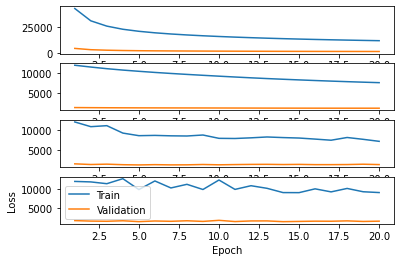

In [46]:
# train the function on various values of lr to find the best one 
alpha = [0.005, 0.01, 0.05, 0.1]
epochs = 20

#plot 4 subplots with the fifferent values of alpha
fig, axs = plt.subplots(4)
for i, a in enumerate(alpha):
  training_loss, validation_loss, training_accuracy, validation_accuracy = nn.fit(train_X, train_Y, epochs, a)

  print("For ", a)
  axs[i].plot(np.arange(1, epochs +1, 1), training_loss,   label="Train")
  axs[i].plot(np.arange(1, epochs +1, 1), validation_loss, label="Validation")
  plt.legend()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

In [47]:
training_loss = None
validation_loss = None
training_accuracy = None
validation_accuracy = None
epochs = 50
learning_rate = 0.005
training_loss, validation_loss, training_accuracy, validation_accuracy = nn.fit(train_X, train_Y, epochs, learning_rate)

  0%|          | 0/50 [00:00<?, ?it/s]

Plot graphs for different types of neural network architectures. Also experiment with different learning rates. No of epochs should be on the $x$-axis and training \& validation loss on the $y$-axis.

Text(0, 0.5, 'Loss')

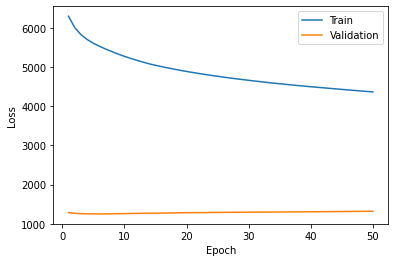

In [48]:
# plot a graph to look at t
plt.plot(np.arange(1,epochs +1, 1), training_loss, label= "Train")
plt.plot(np.arange(1,epochs +1, 1), validation_loss, label= "Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

Predict the labels of test data using the *predict() function*. Skeleton code for this function is already given to you. You may find [np.argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) useful to extract labels.

In [49]:
predicted = nn.predict(test_X)
y_pred = np.argmax(predicted, axis = 1) # predict the labels

Implement and call the evaluate function. Pass true labels and predicted labels of test data as parameters and report your results.

In [50]:
accuracy, matrix, f1 = nn.evaluate( test_Y, y_pred, untested) #evaluation metrics
print("Accuracy= ", accuracy)
print(matrix)
print("F1 score= ", f1)

Accuracy=  0.9471
[[ 959    1    1    0    2    7    5    2    1    2]
 [   0 1118    3    3    1    3    3    1    3    0]
 [   6    8  977    8    2    4    6   12    9    0]
 [   0    3   17  923    0   39    1    9    8   10]
 [   2    0    7    1  930    1   12    3    3   23]
 [   6    4    6   23    0  823    8    0   12   10]
 [  15    3    4    1    6    8  916    0    5    0]
 [   5    7   15   10    7    0    0  974    2    8]
 [  10    0    6    9    7   12   16    4  903    7]
 [   5    4    2    6   24    6    0    8    6  948]]
F1 score=  0.9471


# **Part 2**

In this part, you will get hands-on experience in using tensorflow libraries to implement a CNN for the same mnist dataset used in part 1. It will also give you an idea which model performs better. For this part it is recommended to use Google Colab and GPU for faster training.

For this part, you will need to reshape both testX and trainX. We want the shape of trainX to be (60000,28,28,1) and the shape of testX to be (10000,28,28,1). Use np.reshape for this.

In [51]:
#reshape here
trainX, trainY, testX, testY, untest = load_dataset()
trainX = trainX.reshape(trainX.shape[0], 28, 28, 1)
testX = testX.reshape(testX.shape[0], 28, 28, 1)

In [52]:
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape)) #should print "Train: X=(60000,28,28,1), y=(60000,10)"
print('Test: X=%s, y=%s' % (testX.shape, testY.shape)) #should print "Test: X=(10000,28,28,1), y=(10000,10)"

Train: X=(60000, 28, 28, 1), y=(60000, 10)
Test: X=(10000, 28, 28, 1), y=(10000, 10)


In [64]:
# Do not change this, it will be used in the end
labels={}
for i in range(10):
  labels[str(i)] = i

In [65]:
# Hyperparameters, you can change them accordingly to get higher accuracy on test dataset
input_shape = (28,28,1)
learning_rate = 0.1
batch_size = 100
epochs = 10

# Training

Build model here. Use Functional API of tensorflow to this. You can have a look [here](https://www.tensorflow.org/guide/keras/functional) to understand how this works.
Model architecture:
*   See the image below for model architecture 
*   For convolutional layer, use kernel size as (3,3) and use relu as activation function
*   For Max Pooling layer, use pool size = (2,2)
*   Last Layer has softmax activation, the second last layer has relu activation
*   Total number of parameters should be 542,230







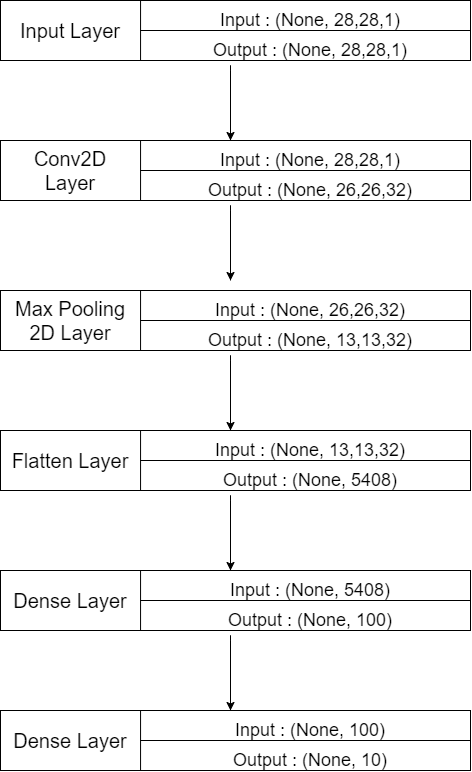

In [66]:
from tensorflow import keras
def define_model():
  #use tensorflow layers to create model
  input = Input(shape=input_shape)
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= input_shape))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(100, activation='relu')) 
  model.add(layers.Dense(10, activation='softmax'))

  return model

In [67]:
#create model here and print summary
nn = define_model()
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               540900    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________


Compile model here by using optimizer = Adam, loss = categorical_crossentropy and metrics = accuracy. Use model.compile() for this. See [this](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) documentation. For seeing how to use optimizer, see [this](https://keras.io/api/optimizers/) link.

In [68]:
#compile model here
opt = keras.optimizers.Adam(learning_rate=0.01)
nn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Fit your model here. Use model.fit().  See [this](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) documentation to understand model.fit(). Pass in argument steps_per_epoch = floor(Total_train_images/batch_size) 

In [69]:
#fit your model here
import math
step = math.floor(trainX.shape[0] / batch_size)
hist = nn.fit(trainX, trainY, validation_data = (testX, testY), epochs = epochs, steps_per_epoch = step)

Epoch 1/10
600/600 [==============================] - 6s 9ms/step - loss: 0.1490 - accuracy: 0.9544 - val_loss: 0.0866 - val_accuracy: 0.9713
Epoch 2/10
600/600 [==============================] - 5s 8ms/step - loss: 0.0541 - accuracy: 0.9831 - val_loss: 0.0541 - val_accuracy: 0.9841
Epoch 3/10
600/600 [==============================] - 5s 9ms/step - loss: 0.0390 - accuracy: 0.9874 - val_loss: 0.0716 - val_accuracy: 0.9782
Epoch 4/10
600/600 [==============================] - 5s 8ms/step - loss: 0.0293 - accuracy: 0.9908 - val_loss: 0.0827 - val_accuracy: 0.9787
Epoch 5/10
600/600 [==============================] - 5s 8ms/step - loss: 0.0250 - accuracy: 0.9922 - val_loss: 0.0756 - val_accuracy: 0.9827
Epoch 6/10
600/600 [==============================] - 5s 8ms/step - loss: 0.0287 - accuracy: 0.9911 - val_loss: 0.1063 - val_accuracy: 0.9770
Epoch 7/10
600/600 [==============================] - 5s 9ms/step - loss: 0.0240 - accuracy: 0.9930 - val_loss: 0.1203 - val_accuracy: 0.9799
Epoch 

Plot the loss and accuracy graphs of training. Use hist.history['loss'] and hist.history['accuracy'] where hist is returned by model.fit()

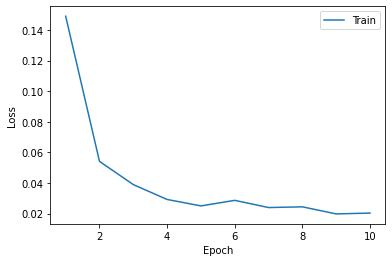

In [70]:
#Plot Loss
loss = hist.history['loss']
plt.plot(np.arange(1, epochs + 1, 1), loss, label= "Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


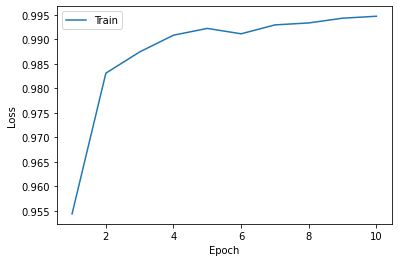

In [71]:
#Plot Accuracy
accuracy = hist.history['accuracy']
plt.plot(np.arange(1, epochs + 1, 1), accuracy, label= "Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Testing

Make predictions on Test Data. Use model.predict() for this

In [72]:
# make predictions here
y_pred = nn.predict(testX)

Extract class label from the predictions. You may find np.argmax() useful for this

In [73]:
# Extract class labels
y_pred = (np.argmax(y_pred, axis = 1))

Calculate and print accuracy on test data.

In [74]:
# Accuracy Score
accuracy_score(testY, to_categorical(y_pred))

0.9843

Plot the confusion matrix here using the sklearn library. Have a look [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for this.

In [75]:
matrix = confusion_matrix(untest, y_pred)

In [76]:
import pandas as pd
import seaborn as sns
def plot_confusion_matrix(conf_mat):
    classes = list(labels.keys())
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.1)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 10})
    plt.show()

Use the above function for plotting confusion matrix.

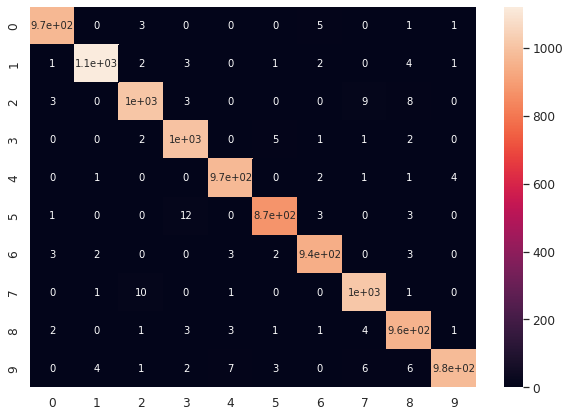

In [77]:
plot_confusion_matrix(matrix)